In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate

In [2]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)

In [3]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [4]:
# left
node_left, edge_left, timestamp_left = return_nm(df_left)

In [5]:
# node_leftとedge_leftを組みにしてdf_leftを作成
df_left = pd.DataFrame({'node': node_left, 'edge': edge_left})
# df_leftのnodeを昇順にして並び替え
df_left = df_left.sort_values(by='node')
# インデックスを振り直す
df_left = df_left.reset_index(drop=True)
df_left.head()

,node,edge
0,106,190
1,136,221
2,173,312
3,215,368
4,217,494


In [13]:
def model_uniform(x, kappa):
    Np = (1 + np.sqrt((1 + (32 * x[0])) / kappa)) / 2
    return Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np))

In [18]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_uniform, xdata=df_left["edge"], ydata=df_left["node"], p0=[0.0001])

print(r"kappa:", params[0])

+------------------+
| Estimating       |
+------------------+
kappa: 4.399227449465761e-06


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_17327/1680263957.py:2: RuntimeWarning: invalid value encountered in sqrt
  Np = (1 + np.sqrt((1 + (32 * x[0])) / kappa)) / 2


In [8]:
kappa = params[0]
kappa = round(kappa, 2)
print("+------------------+")
Np_estimated = []
for i in range(len(df_left["edge"])):
    Np_estimated.append( (1 + np.sqrt(1 + ((32 * df_left["edge"][i]) / kappa))) / 2)

print("+       DONE       +")
print("+------------------+")


+------------------+
+       DONE       +
+------------------+


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_17327/4061977073.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  Np_estimated.append( (1 + np.sqrt(1 + ((32 * df_left["edge"][i]) / kappa))) / 2)


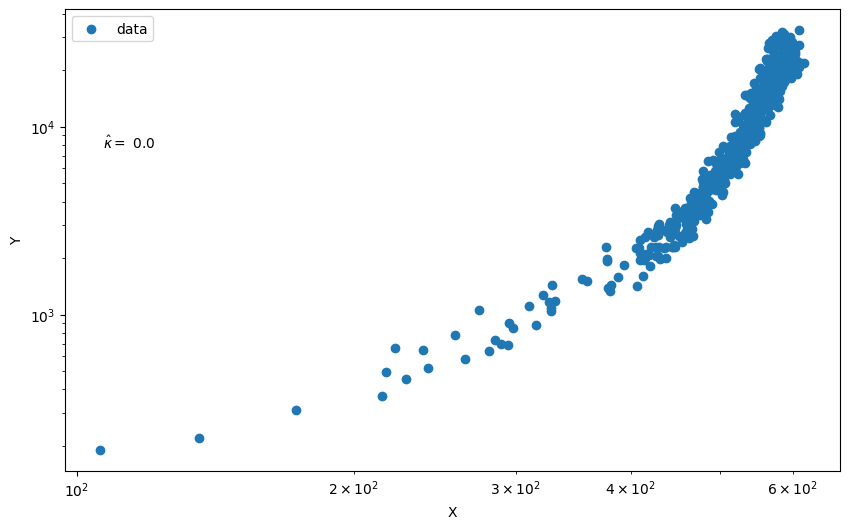

In [38]:
# 可視化
plt.figure(figsize=(10, 6))
plt.scatter(df_left["node"], df_left["edge"], label='data')
plt.plot(df_left["node"], Np_estimated)
plt.text(0.05, 0.70, r'$\hat{\kappa}=$ ' + str(kappa), transform=plt.gca().transAxes)
plt.xlabel('X')
plt.ylabel('Y')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [9]:
# Eq8
N = []
for i in range(len(df_left["edge"])):
    N.append(Np_estimated[i] * (1 - 2/(kappa * Np_estimated[i]) * (1 - (1 - kappa/2)**Np_estimated)))
# Eq9
M = []
for i in range(len(df_left["edge"])):
    M.append((kappa * Np_estimated[i] * (Np_estimated[i] - 1)) / 8)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_17327/10527523.py:4: RuntimeWarning: invalid value encountered in scalar multiply
  N.append(Np_estimated[i] * (1 - 2/(kappa * Np_estimated[i]) * (1 - (1 - kappa/2)**Np_estimated)))
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_17327/10527523.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  M.append((kappa * Np_estimated[i] * (Np_estimated[i] - 1)) / 8)


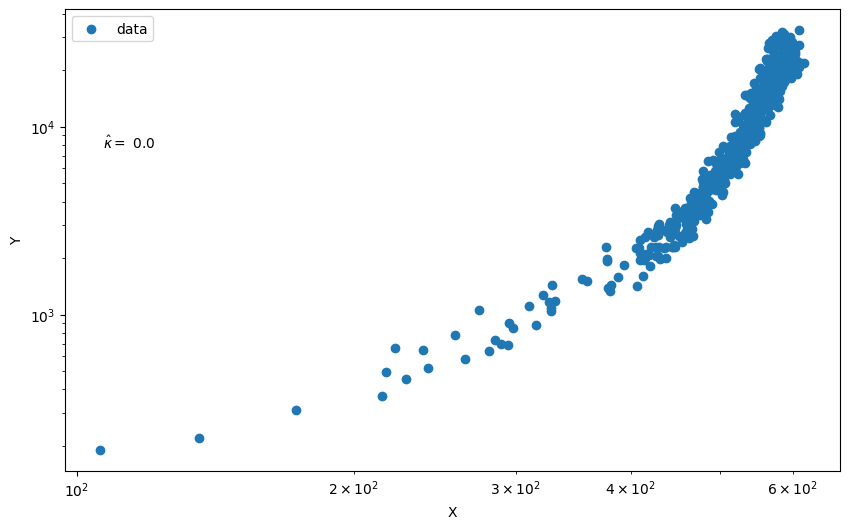

In [10]:
# 可視化
plt.figure(figsize=(10, 6))
plt.scatter(df_left["node"], df_left["edge"], label='data')
plt.plot(N, M)
plt.text(0.05, 0.70, r'$\hat{\kappa}=$ ' + str(kappa), transform=plt.gca().transAxes)
plt.xlabel('X')
plt.ylabel('Y')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [6]:
max(df_left["node"])

618

In [7]:
def model_uniform_2(x, Np):
    kappa = (8 * x[0]) / (Np * (Np - 1))
    first = (1 - (kappa / 2))**Np
    second = 1 - first
    third = (2 / (kappa * Np)) * second
    fourth = 1 - third
    fifth = Np * fourth
    return fifth

In [22]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_uniform_2, df_left["edge"], df_left["node"], p0=[max(df_left["node"])])
# params, _ = optimize.curve_fit(model_uniform_2, df_left["edge"], df_left["node"], p0=[max(df_left["node"])])

print(r"Np:", params[0])

+------------------+
| Estimating       |
+------------------+
Np: 20311.389975757324


In [24]:
Np_hat = params[0]
Np_hat = round(Np_hat, 2)
print("+------------------+")
# kappa_estimatedというnp.arrayを作成
kappa_estimated = []
for i in range(len(df_left["edge"])):
    kappa_estimated.append( (8 * df_left["edge"][i]) / (Np_hat**2 - Np_hat))

kappa_estimated = np.array(kappa_estimated)

print("+       DONE       +")
print("+------------------+")

+------------------+
+       DONE       +
+------------------+


In [25]:
kappa_estimated.shape

(608,)

In [26]:
# Eq8
N = []
for i in range(len(kappa_estimated)):
    N.append( Np_hat * ( 1 - (2/(kappa_estimated[i] * Np_hat)) * (1 - (1 - (kappa_estimated[i]/2))**Np_hat ) ) )
# Eq9
M = []
for i in range(len(kappa_estimated)):
    M.append(((kappa_estimated[i] * Np_hat**2) - (kappa_estimated[i] * Np_hat)) / 8)

In [27]:
print(len(N))
print(len(M))
# NとMを組みにしてdf_left_fitを作成
df_left_fit = pd.DataFrame({'node': N, 'edge': M})

608
608


In [28]:
# df_left_fitのnodeとedgeのサイズを確認
df_left_fit.head()

,node,edge
0,375.304691,190.0
1,435.657176,221.0
2,611.414310,312.0
3,718.538635,368.0
4,956.726488,494.0


In [ ]:
# df_left_fitのnodeを

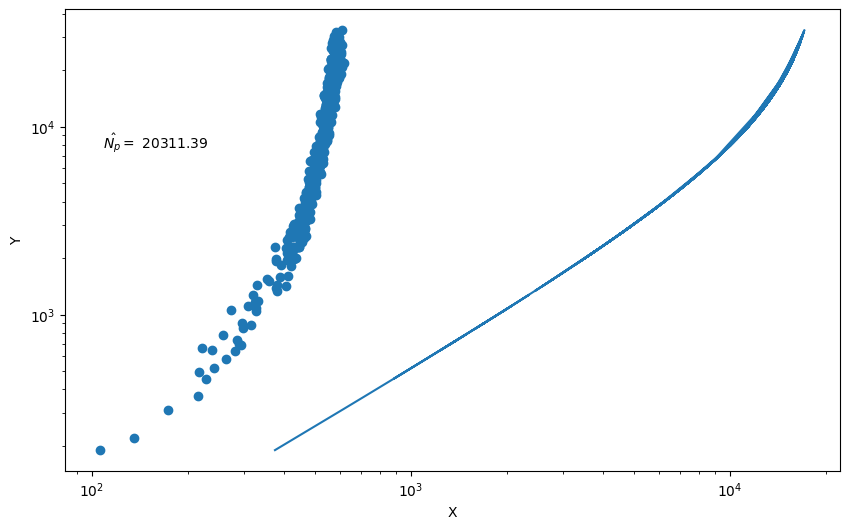

In [30]:
# 可視化
plt.figure(figsize=(10, 6))
plt.scatter(df_left["node"], df_left["edge"], label='data')
plt.plot(df_left_fit["node"], df_left_fit["edge"], label='fit')
plt.text(0.05, 0.70, r'$\hat{N_{p}}=$ ' + str(Np_hat), transform=plt.gca().transAxes)
plt.xlabel('X')
plt.ylabel('Y')
plt.xscale('log')
plt.yscale('log')
#plt.legend(loc='best')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


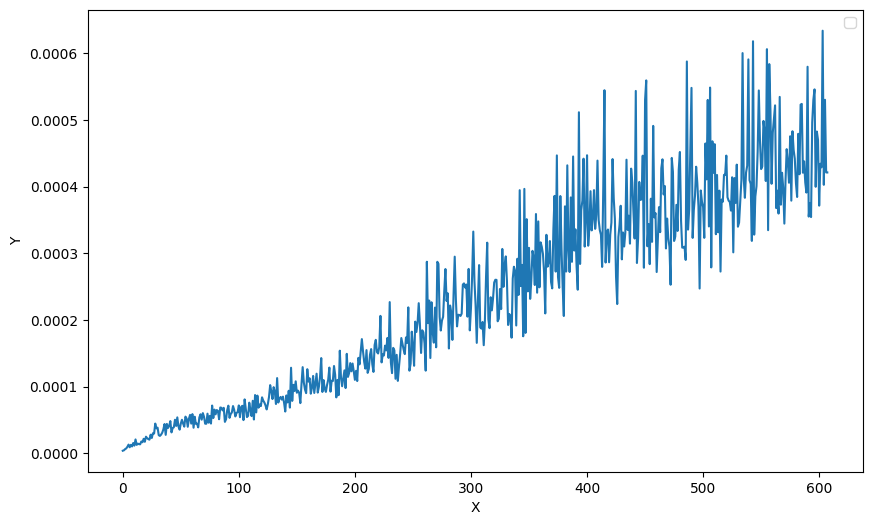

In [32]:
# kappa_estimatedをプロット
plt.figure(figsize=(10, 6))
plt.plot(kappa_estimated)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='best')
plt.show()